In [ ]:
 !pip install transformers datasets evaluate nltk rouge emoji wordcloud tensorflow
 !pip install tf-keras pip install numpy
!pip install --upgrade datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 43.0 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement install (from versions: none)
ERROR: No matching distribution found for install
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 23.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.

In [ ]:
from google.colab import drive
import pandas as pd
import re
import tensorflow as tf
import nltk
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from evaluate import load
from rouge import Rouge
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

**Explore the Query Data**

In [ ]:
### Step 1: Load and Explore Data
data_path = '/content/water-irrigation.csv'


In [ ]:
df = pd.read_csv(data_path)

In [ ]:
# Checking column names and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3851 entries, 0 to 3850
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ANSWER              3851 non-null   object
 1   QUESTION.question   3851 non-null   object
 2   QUESTION.paragraph  3851 non-null   object
dtypes: object(3)
memory usage: 90.4+ KB


In [ ]:
df.describe()

,ANSWER,QUESTION.question,QUESTION.paragraph
count,3851,3851,3851
unique,3823,3815,2077
top,Water Management Technologies for Sustainable ...,What type of tines is the planter fitted with?,5.1.3 Advantage of drip irrigation
freq,3,3,23


In [ ]:
#printing the shape of the data
df.shape

(3851, 3)

In [ ]:
df["QUESTION.question"][1]

'Who is the first author listed for the document?'

In [ ]:
df["ANSWER"][1]

'R.S. Chhillar'

In [ ]:
# word count in the review
def words_in_review(text):
  word_list = text.split()
  return len(word_list)

df['num_words'] = df['QUESTION.question'].apply(words_in_review)
df.head()

,ANSWER,QUESTION.question,QUESTION.paragraph,num_words
0,Water Management Technologies for Sustainable ...,What is the title of the document?,Water Management Technologies for Sustainable ...,7
1,R.S. Chhillar,Who is the first author listed for the document?,R.S. Chhillar,9
2,Farmer’s Participatory Action Research Programme,Which program is mentioned in the document?,Farmer’s Participatory Action Research Programme,7
3,Water Technology Centre,Which institution published this document?,Water Technology Centre,5
4,New Delhi-110012,Where is the Indian Agricultural Research Inst...,New Delhi-110012,8


**Data Splitting**

In [ ]:
# Split the Dataset
# Divide into training (80%), validation (10%), and test (10%) sets
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 3080
Validation set size: 385
Test set size: 386


**Visualizations**

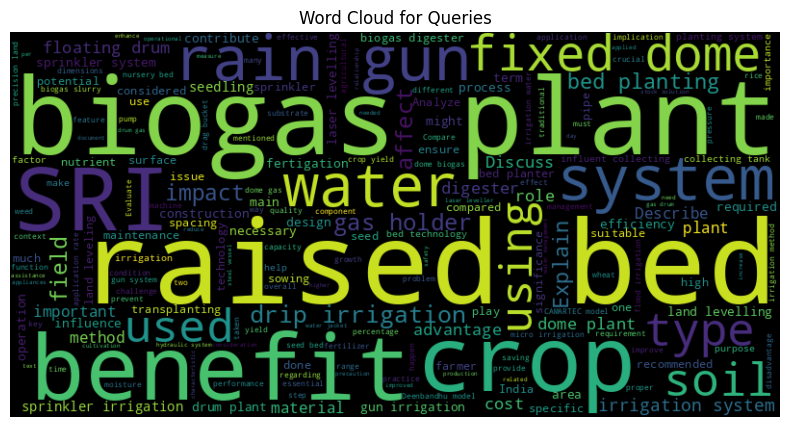

In [ ]:
# Word Mapping (Word Clouds)
# Queries
query_text = ' '.join(train_df['QUESTION.question'])
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(query_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Queries')
plt.show()

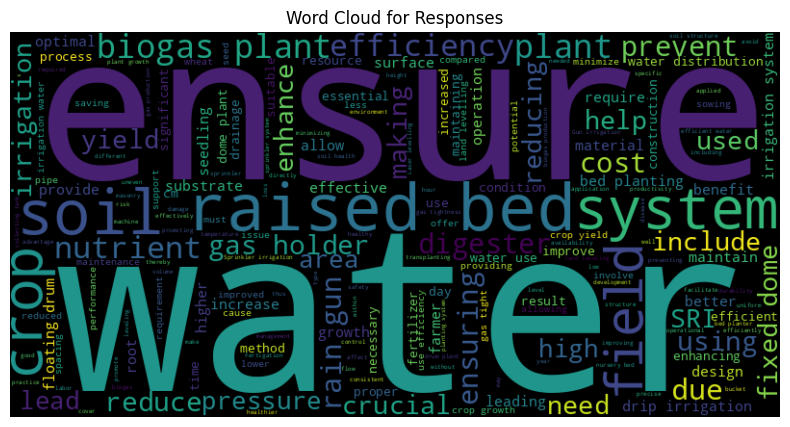

In [ ]:
# Responses
response_text = ' '.join(train_df['ANSWER'])
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(response_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Responses')
plt.show()

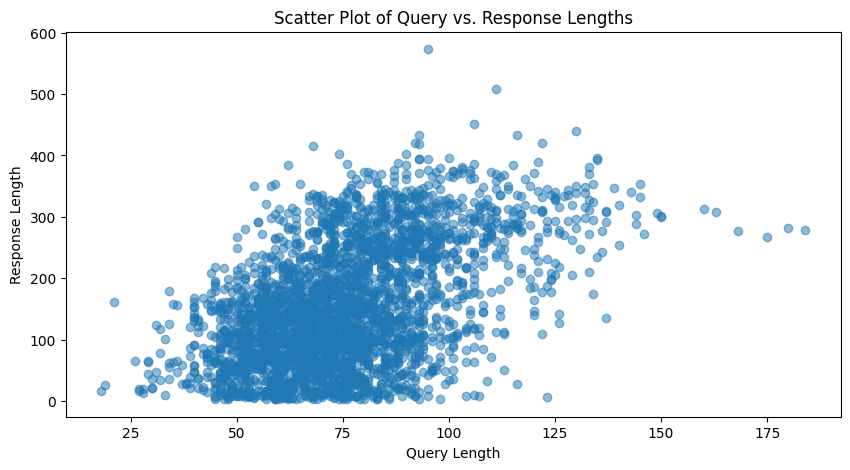

In [ ]:
# Scatter Mapping (Query vs. Response Lengths)
train_df['QUESTION.question_length'] = train_df['QUESTION.question'].apply(len)
train_df['ANSWER_length'] = train_df['ANSWER'].apply(len)
plt.figure(figsize=(10, 5))
plt.scatter(train_df['QUESTION.question_length'], train_df['ANSWER_length'], alpha=0.5)
plt.xlabel('Query Length')
plt.ylabel('Response Length')
plt.title('Scatter Plot of Query vs. Response Lengths')
plt.show()

**Data Cleaning & Filling Missing Values**

In [ ]:
df.isnull().sum()

,0
ANSWER,0
QUESTION.question,0
QUESTION.paragraph,0
num_words,0


In [ ]:
def clean_text(text):
    # Handle both string and pandas Series input
    if isinstance(text, pd.Series):
        text = text.apply(lambda x: str(x) if pd.notnull(x) else '')
    else:
        text = str(text) if text is not None else ''

    text = re.sub(r'Hey\s+[A-Za-z]+\s*[!|,]', '', text, flags=re.IGNORECASE)
    text = re.sub(r'[A-Za-z]+,\s*', '', text, flags=re.IGNORECASE)

    # Remove standalone names before punctuation
    text = re.sub(r'\b[A-Za-z]+\s*(?=[.!?])', '', text, flags=re.IGNORECASE)

    # Remove "Hey" standalone
    text = re.sub(r'\bHey\b', '', text, flags=re.IGNORECASE)

    # Remove special characters (keep only letters and spaces)
    text = re.sub(r"[^a-zA-Z\s]", "", text)

    #  whitespace normalization
    text = re.sub(r'\s+', ' ', text).strip()

    return text


In [ ]:
# Clean both queries and responses
df['QUESTION.question'] = df['QUESTION.question'].apply(clean_text)
df['ANSWER'] = df['ANSWER'].apply(clean_text)

# Remove duplicates
df.drop_duplicates(inplace=True)

In [ ]:
# Verify cleaning and duplicate removal by printing sample rows
print("Sample cleaned data after duplicate removal:")
print(df[['QUESTION.question', 'ANSWER']].head())

Sample cleaned data after duplicate removal:
                                   QUESTION.question  \
0                           What is the title of the   
1             Who is the first author listed for the   
2                  Which program is mentioned in the   
3                   Which institution published this   
4  Where is the Indian Agricultural Research Inst...   

                                              ANSWER  
0  Water Management Technologies for Sustainable ...  
1                                           Chhillar  
2    Farmers Participatory Action Research Programme  
3                            Water Technology Centre  
4                                          New Delhi  


**Tokenization for T5 Base**



In [ ]:
tokenizer= T5Tokenizer.from_pretrained("t5-base")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [ ]:
def preprocess_data(examples):
    """Tokenize queries and responses for T5 model."""
    inputs = tokenizer(examples["QUESTION.question"], padding="max_length", truncation=True, max_length=128)
    targets = tokenizer(examples["ANSWER"], padding="max_length", truncation=True, max_length=128)
    inputs["labels"] = targets["input_ids"]
    return inputs

In [ ]:
# Convert to Hugging Face Datasets
# Transform pandas DataFrames into a format suitable for training
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Apply Tokenization
# Tokenize all datasets for model input
train_dataset = train_dataset.map(preprocess_data, batched=True)
val_dataset = val_dataset.map(preprocess_data, batched=True)
test_dataset = test_dataset.map(preprocess_data, batched=True)

Map:   0%|          | 0/3080 [00:00<?, ? examples/s]

Map:   0%|          | 0/385 [00:00<?, ? examples/s]

Map:   0%|          | 0/386 [00:00<?, ? examples/s]

In [ ]:
train_dataset[0]

{'ANSWER': 'In regions with water scarcity and insufficient surface irrigation.',
 'QUESTION.question': 'Where can the sprinkler method of irrigation be more beneficial in India?',
 'QUESTION.paragraph': 'These methods are becoming increasingly popular in India in regions of water scarcity where water is insufficient to irrigate the command area by the surface method.',
 'num_words': 12,
 'QUESTION.question_length': 73,
 'ANSWER_length': 67,
 '__index_level_0__': 912,
 'input_ids': [2840,
  54,
  8,
  14929,
  52,
  1573,
  13,
  21455,
  36,
  72,
  6473,
  16,
  1547,
  58,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  

**Model Training**

In [ ]:
import tensorflow as tf

# Define Collate Function
# This stacks data into tensors for TensorFlow compatibility
collate_fn = lambda x: {
    'input_ids': tf.stack([tf.convert_to_tensor(item['input_ids']) for item in x]),
    'attention_mask': tf.stack([tf.convert_to_tensor(item['attention_mask']) for item in x]),
    'labels': tf.stack([tf.convert_to_tensor(item['labels']) for item in x]),
}

# Convert to TensorFlow Datasets
# Prepare datasets for training with batching and shuffling
# Using 'tf' format instead of 'numpy' for better compatibility
# Reduced batch size to 32 to mitigate OOM error
train_tf_dataset = train_dataset.to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'labels'],
    shuffle=True,
    batch_size=5,  # Reduced batch size
    collate_fn=collate_fn,
)

val_tf_dataset = val_dataset.to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'labels'],
    shuffle=False,
    batch_size=5,  # Reduced batch size
    collate_fn=collate_fn,
)

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


Epoch 1/15
616/616 [==============================] - 293s 368ms/step - loss: 1.5372 - val_loss: 0.7487
Epoch 2/15
616/616 [==============================] - 218s 354ms/step - loss: 0.7692 - val_loss: 0.6501
Epoch 3/15
616/616 [==============================] - 217s 352ms/step - loss: 0.6964 - val_loss: 0.6262
Epoch 4/15
616/616 [==============================] - 219s 355ms/step - loss: 0.6628 - val_loss: 0.6099
Epoch 5/15
616/616 [==============================] - 218s 353ms/step - loss: 0.6366 - val_loss: 0.5980
Epoch 6/15
616/616 [==============================] - 219s 355ms/step - loss: 0.6169 - val_loss: 0.5868
Epoch 7/15
616/616 [==============================] - 218s 354ms/step - loss: 0.5968 - val_loss: 0.5780
Epoch 8/15
616/616 [==============================] - 218s 354ms/step - loss: 0.5781 - val_loss: 0.5700
Epoch 9/15
616/616 [==============================] - 218s 355ms/step - loss: 0.5605 - val_loss: 0.5633
Epoch 10/15
616/616 [==============================] - 218s 353m

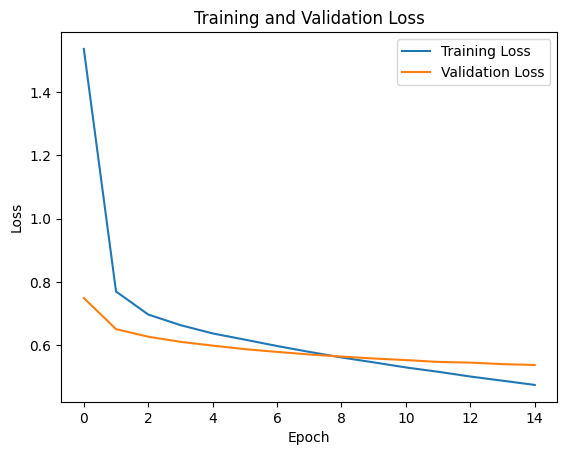

('fine_tuned_t5_irrigation_model/tokenizer_config.json',
 'fine_tuned_t5_irrigation_model/special_tokens_map.json',
 'fine_tuned_t5_irrigation_model/spiece.model',
 'fine_tuned_t5_irrigation_model/added_tokens.json')

In [ ]:
from transformers import TFT5ForConditionalGeneration, T5Tokenizer
import tensorflow as tf

# Load T5-base Model
# Use T5-base for all parts as specified
model = TFT5ForConditionalGeneration.from_pretrained("t5-base")

# Compile the Model
# Use Adam optimizer and a standard Keras loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss)

# Train the Model
# Fine-tune with validation for 2 epochs (increase epochs for better tuning)
history = model.fit(train_tf_dataset, validation_data=val_tf_dataset, epochs=15)  # Increased to 3 for better fine-tuning

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save the Model and Tokenizer
# Store the fine-tuned model for later use
model.save_pretrained("fine_tuned_t5_irrigation_model")
tokenizer.save_pretrained("fine_tuned_t5_irrigation_model")

**Saving The model**

In [ ]:
# Save the Model and Tokenizer to the Google Drive path
# Store the fine-tuned model for later use
model_save_path = "/content/drive/MyDrive/Irrigation_model"
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"Model and tokenizer saved to: {model_save_path}")

Model and tokenizer saved to: /content/drive/MyDrive/Irrigation_model


**Load the Model**

In [ ]:
# Load the Model
# Load the trained model and tokenizer using the TensorFlow class
# The path should be to the directory where you saved the model
model_load_path = "/content/drive/MyDrive/Irrigation_model" # Use the same path for loading
model = TFT5ForConditionalGeneration.from_pretrained(model_load_path)
tokenizer = T5Tokenizer.from_pretrained(model_load_path)

print("TensorFlow model and tokenizer loaded successfully.")


All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at /content/drive/MyDrive/Irrigation_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


TensorFlow model and tokenizer loaded successfully.


**Evaluation Model**

In [ ]:
# Calculate BLEU Score per prediction
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import tensorflow as tf
import pandas as pd # Ensure pandas is imported if not already
# Make sure you have loaded your model and tokenizer before this cell
# e.g., model = TFT5ForConditionalGeneration.from_pretrained(model_load_path)
#       tokenizer = T5Tokenizer.from_pretrained(model_load_path)


# Generate predictions for the test set
test_questions = test_df['QUESTION.question'].tolist()
predictions = []
references = test_df['ANSWER'].tolist()

print("Generating predictions for the test set...")
for i, question in enumerate(test_questions):
    # Use TensorFlow tensors
    input_ids = tokenizer(question, return_tensors="tf", max_length=250, truncation=True).input_ids

    outputs = model.generate(
        input_ids,
        max_length=128,
        num_beams=5,
        early_stopping=True
    )
    # outputs will be TensorFlow tensors, decode them
    predictions.append(tokenizer.decode(outputs[0], skip_special_tokens=True))
    print(f"Generated prediction for sample {i+1}/{len(test_questions)}")

# Add predictions to the test DataFrame
test_df['predictions'] = predictions

bleu_scores_per_sample = []

print("\nCalculating BLEU scores per sample...")
for i, (pred, ref) in enumerate(zip(predictions, references)):
    bleu = sentence_bleu([ref.split()], pred.split(), smoothing_function=SmoothingFunction().method1)
    bleu_scores_per_sample.append(bleu)
    print(f"Calculated BLEU score for sample {i+1}/{len(predictions)}")

# You can now add the individual BLEU scores back to your test_df
test_df['bleu_score'] = bleu_scores_per_sample

# Display samples with their generated prediction and BLEU score
print("\nSample Predictions and BLEU Scores:")
display(test_df[['QUESTION.question', 'ANSWER', 'predictions', 'bleu_score']].head())

# Calculate the average BLEU score as before
avg_bleu = sum(bleu_scores_per_sample) / len(bleu_scores_per_sample)
print(f"\nAverage BLEU Score: {avg_bleu}")

# Calculate ROUGE Scores (This part remains the same)
from rouge import Rouge
rouge = Rouge()
rouge_scores = rouge.get_scores(predictions, references, avg=True)

# Experiment Table (Update to include average BLEU)
results = pd.DataFrame({
    'Metric': ['BLEU (Average)', 'ROUGE-1 F1', 'ROUGE-2 F1', 'ROUGE-L F1'],
    'Score': [avg_bleu, rouge_scores['rouge-1']['f'], rouge_scores['rouge-2']['f'], rouge_scores['rouge-l']['f']]
})
print("\nExperiment Results:")
display(results)

Generating predictions for the test set...
Generated prediction for sample 1/386
Generated prediction for sample 2/386
Generated prediction for sample 3/386
Generated prediction for sample 4/386
Generated prediction for sample 5/386
Generated prediction for sample 6/386
Generated prediction for sample 7/386
Generated prediction for sample 8/386
Generated prediction for sample 9/386
Generated prediction for sample 10/386
Generated prediction for sample 11/386
Generated prediction for sample 12/386
Generated prediction for sample 13/386
Generated prediction for sample 14/386
Generated prediction for sample 15/386
Generated prediction for sample 16/386
Generated prediction for sample 17/386
Generated prediction for sample 18/386
Generated prediction for sample 19/386
Generated prediction for sample 20/386
Generated prediction for sample 21/386
Generated prediction for sample 22/386
Generated prediction for sample 23/386
Generated prediction for sample 24/386
Generated prediction for sampl

,QUESTION.question,ANSWER,predictions,bleu_score
1915,How does planting on beds affect lodging?,Lodging is greater with 3 rows of wheat per be...,Planting on beds reduces lodging by reducing t...,0.010863
3674,What is the maximum application rate for clay ...,The maximum application rate for clay loam or ...,The maximum application rate for clay loam or ...,0.668771
2002,What is the required horsepower for operating ...,The raised bed planter can be operated with a ...,The required horsepower for operating the rais...,0.068633
3180,What irrigation and drainage feature should ac...,Raised nursery beds should have 30-40 cm drain...,Raised nursery beds should be irrigated and dr...,0.086313
578,What is a common wrong notion among farmers re...,They believe planting paddy plants more densel...,A common wrong notion among farmers regarding ...,0.040991



Average BLEU Score: 0.10436399250908364

Experiment Results:


,Metric,Score
0,BLEU (Average),0.104364
1,ROUGE-1 F1,0.330906
2,ROUGE-2 F1,0.172475
3,ROUGE-L F1,0.301738


In [ ]:
## Interactive Chatbot Interface

# Prediction code
# Make sure the clean_text function and the model/tokenizer are loaded in previous cells
def chatbot(Question):
    # Assuming clean_text function is already defined from previous code
    query = clean_text(Question)
    # Use TensorFlow tensors
    input_ids = tokenizer(query, return_tensors="tf", max_length=128, truncation=True).input_ids

    outputs = model.generate(
        input_ids,
        max_length=128,
        num_beams=5,
        early_stopping=True
    )
    # outputs will be TensorFlow tensors, decode them
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

print("\nChatbot Interface:")
while True:
    user_input = input("You: ")
    if user_input.lower() == "exit":
        break
    response = chatbot(user_input)
    print("Chatbot:", response)


Chatbot Interface:
You: What operational procedure should be followed for laser levellers regarding field height?
Chatbot: Operational procedures for laser levellers include ensuring that the laser beam is aligned with the field surface, ensuring proper levelling of the field, and ensuring proper maintenance of the equipment.
You: Why is proper training and education important for biogas technology?
Chatbot: Proper training and education are crucial for biogas plant operators to ensure proper functioning and maintenance of the biogas plant. Proper training and education ensures that biogas plant operators are properly trained and equipped to handle biogas production efficiently.
You: which is the best water pipe for irrigation?
Chatbot: The best water pipe is the one with a long lifespan of 30 years or more.
You: exit
